In [1]:
# !pip install langchain_community neo4j langchain langchain_groq sentence-transformers langchain_huggingface langchain_nvidia_ai_endpoints

# # Installs Unsloth, Xformers (Flash Attention) and all other packages!
# !pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# # We have to check which Torch version for Xformers (2.3 -> 0.0.27)
# from torch import __version__; from packaging.version import Version as V
# xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
# !pip install --no-deps {xformers} trl peft accelerate bitsandbytes triton

In [1]:
import pandas as pd
import numpy as np

from langchain_community.graphs import Neo4jGraph ## Deprecated:  but runs smoothly
# from langchain_neo4j import Neo4jGraph  ## New but results in error
# from langchain_groq import ChatGroq # 
from langchain_openai import ChatOpenAI, OpenAI, OpenAIEmbeddings # not free
from langchain.chains import GraphCypherQAChain
# from google.colab import userdata 
import os

import langchain, langchain_community
print('langchain: ', langchain.__version__)
print('langchain_community: ', langchain_community.__version__)

In [26]:
# get list of all openai models

import openai
client = OpenAI(
    api_key=openapi_key,  # This is the default and can be omitted
)
openai_models = client.models.list()
for model in openai_models:
    print(model.id)


gpt-4o-audio-preview-2024-10-01
gpt-4o-realtime-preview
gpt-4o-realtime-preview-2024-10-01
o1-mini-2024-09-12
dall-e-2
gpt-4-turbo
gpt-4-1106-preview
gpt-3.5-turbo
gpt-3.5-turbo-0125
gpt-3.5-turbo-instruct
babbage-002
davinci-002
whisper-1
gpt-4o-mini-2024-07-18
dall-e-3
gpt-4o-mini
text-embedding-3-small
gpt-3.5-turbo-16k
gpt-4-0125-preview
gpt-4-turbo-preview
omni-moderation-latest
gpt-4o-2024-05-13
omni-moderation-2024-09-26
tts-1-hd-1106
chatgpt-4o-latest
gpt-4
gpt-4-0613
o1-mini
gpt-4o-2024-08-06
gpt-4o
o1-preview
o1-preview-2024-09-12
tts-1-hd
text-embedding-ada-002
gpt-3.5-turbo-1106
gpt-4o-audio-preview
tts-1
tts-1-1106
gpt-3.5-turbo-instruct-0914
text-embedding-3-large
gpt-4o-realtime-preview-2024-12-17
gpt-4o-mini-realtime-preview
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-2024-11-20
gpt-4o-audio-preview-2024-12-17
gpt-4o-mini-audio-preview
gpt-4o-mini-audio-preview-2024-12-17
gpt-4-turbo-2024-04-09


In [2]:

from secret_key import openapi_key
os.environ["OPENAI_API_KEY"] = openapi_key

# Prepare Data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/projectwilsen/neo4j_live/main/data/dataset.csv')
df.head()

,id,name,company,education,languages,industry,country,degree,joining_year,age
0,paul-lukes-906608134,Paul Lukes,Toolbox Creative,California College of the Arts,English|Czech,Advertising Services,United States,Master,2017,28
1,roberto-merola-baa923103,Roberto Merola,Capgemini,Université libre de Bruxelles,English|Italian|French|Dutch|German,IT Services and IT Consulting,Belgium,Bachelor,2017,31
2,minju-hong-bsn-rn-1a7801239,"Minju Hong, BSN, RN",University of Washington Medical Center,University of Washington School of Nursing,Korean|English,Hospitals and Health Care,United States,Master,2018,28
3,prateek-chitpur-710a1a12a,Prateek Chitpur,George Mason University,George Mason University Education George Mason...,English|Hindi|Marathi|Kannada|Telugu,Higher Education,United States,Bachelor,2016,28
4,aadcampos,Alexandre Campos,Serpro - Serviço Federal de Processamento de D...,Unichristus,English,IT Services and IT Consulting,Brazil,Bachelor,2017,35


In [4]:
len(df)

30

In [5]:
# neo4j_url = userdata.get("NEO4J_CONNECTION_URL")
# neo4j_user = userdata.get("NEO4J_USER")
# neo4j_password = userdata.get("NEO4J_PASSWORD")
# graph = Neo4jGraph(url=neo4j_url,username=neo4j_user,password=neo4j_password,sanitize=True,enhanced_schema=True)

In [6]:
# database credentials
uri = "bolt://localhost:7687"
auth = ("neo4j", "password")

In [7]:
# connect to the database which is running on the localhost (It can be empty. We will populate it with the data by running the code below)
graph = Neo4jGraph(url=uri,username=auth[0],password=auth[1],sanitize=True,enhanced_schema=True)


C:\Users\mgupta70.ASURITE\AppData\Local\Temp\ipykernel_30536\1598417561.py:2: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph(url=uri,username=auth[0],password=auth[1],sanitize=True,enhanced_schema=True)
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationsh

Run this code to insert your data from csv into Neo4J (Only one time)

In [8]:
# people_query = """
# LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/projectwilsen/neo4j_live/main/data/dataset.csv'
# AS row
# MERGE (person:Person {name: row.name, age:row.age, degree: row.degree, joining_year: row.joining_year, age: row.age})
# MERGE (company:Company {name: row.company})
# MERGE (school:School {name: row.education})
# MERGE (industry:Industry {name: row.industry})
# MERGE (country:Country {name: row.country})

# FOREACH (lang in split(row.languages, '|') |
#     MERGE (language:Language {name:trim(lang)})
#     MERGE (person)-[:SPEAKS]->(language))

# MERGE (person)-[:WORKS_IN]->(company)
# MERGE (person)-[:LIVES_IN]->(country)
# MERGE (person)-[:EDUCATED_AT]->(school)
# MERGE (company)-[:IS_IN]->(industry)
# """

# graph.query(people_query)

In [9]:
graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Person**
  - `age`: STRING Example: "28"
  - `degree`: STRING Available options: ['Master', 'Bachelor']
  - `joining_year`: STRING Available options: ['2017', '2018', '2016', '2019']
  - `name`: STRING Example: "Paul Lukes"
- **Company**
  - `name`: STRING Example: "Toolbox Creative"
- **School**
  - `name`: STRING Example: "California College of the Arts"
- **Industry**
  - `name`: STRING Available options: ['Advertising Services', 'IT Services and IT Consulting', 'Hospitals and Health Care', 'Higher Education', 'Financial Services', 'Software Development', 'Real Estate']
- **Country**
  - `name`: STRING Example: "United States"
- **Language**
  - `name`: STRING Example: "English"
Relationship properties:

The relationships:
(:Person)-[:SPEAKS]->(:Language)
(:Person)-[:WORKS_IN]->(:Company)
(:Person)-[:LIVES_IN]->(:Country)
(:Person)-[:EDUCATED_AT]->(:School)
(:Company)-[:IS_IN]->(:Industry)


# Set Up Model

Get you Groq API: https://console.groq.com/keys

In [10]:
# groq_api_key = userdata.get("GROQ_API")
# cypher_model = ChatGroq(temperature=0, model_name="llama-3.1-8b-instant", groq_api_key = groq_api_key)
# # qa_model = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile", groq_api_key = groq_api_key)
# qa_model = ChatGroq(temperature=0, model_name="gemma2-9b-it", groq_api_key = groq_api_key)
# # qa_model = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key = groq_api_key)

In [27]:
# modifying above code to use OpenAI instead of GROQ
# we can have separate models for cypher and qa but for now we will use the same model

cypher_model = ChatOpenAI(temperature=0, model_name='gpt-4')
qa_model = ChatOpenAI(temperature=0, model_name='gpt-4')

# Trial 1 ( without any enhancement )

List of Questions

In [12]:
questions = ["List all companies in advertising services industry!",
             "Where is Paul Lukes working?",
             "A worker residing in Canada who is proficient in Vietnamese?",
             "How many worker in United States speak Urdu?"]

- cypher_llm: model for translating user question to cypher query language
- qa_llm: model for translating context from db to final answer
- verbose: set to True, so we can see the process behind the scene
- validate_cypher: set to Ture will force the llm to validate the generated cypher based on the provided nodes and properties
- use_function_response: set to True, means we're going to pass the context and leverage function calling. We need to set this to True to handle cases when there's context but the final response is "I don't know the answer

In [ ]:
chain = GraphCypherQAChain.from_llm(graph=graph,
                                    cypher_llm = cypher_model,
                                    qa_llm= qa_model,
                                    verbose=True, # it means that the output will be verbose which basically means that the output will be more detailed
                                    validate_cypher = True, # it means that the cypher query will be validated before running which basically means that the query will be checked for syntax errors
                                    use_function_response = True, # Setting this to True is resulting in an error
                                    allow_dangerous_requests = True, # this is to allow dangerous requests
                                
                                    )

for q in questions:
    print('====== START ======')
    try:
        print(q)
        result = chain.invoke(q)['result']
        print(result)
    except:
        pass
    print('====== END ====== \n')

AttributeError: 'RunnableSequence' object has no attribute 'get'

# Trial 2 - Few Shot Prompting

**Note:** If you're going to add examples that use node properties, make sure to use double curly brackets `{{}}` instead of single curly brackets `{}`. If you use single curly brackets, you'll encounter an error.

In [30]:
examples= [
    {
        "question": "Which workers speak French?",
        "query": "MATCH (p:Person)-[:SPEAKS]->(l:Language {{name: 'French'}}) RETURN p.name",
    },
    {
        "question": "What industries are workers named Emily associated with?",
        "query": "MATCH (p:Person {{name: 'Emily'}})-[:WORKS_IN]->(c:Company)-[:IS_IN]->(i:Industry) RETURN i.name",
    },
    {
        "question": "Which workers live in Canada and speak German?",
        "query": "MATCH (p:Person)-[:LIVES_IN]->(:Country {{name: 'Canada'}}), (p)-[:SPEAKS]->(:Language {{name: 'German'}}) RETURN p.name",
    },
    {
        "question": "In which countries do workers who speak Spanish live?",
        "query": "MATCH (p:Person)-[:SPEAKS]->(:Language {{name: 'Spanish'}})<-[:SPEAKS]-(worker:Person)-[:LIVES_IN]->(c:Country) RETURN DISTINCT c.name AS Country",
    },
    {
        "question": "Which employees are based in China and speak Bahasa?",
        "query": "MATCH (p:Person)-[:LIVES_IN]->(:Country {{name: 'China'}}), (p)-[:SPEAKS]->(:Language {{name: 'Bahasa'}}) RETURN p.name",
    },
    {
        "question": "What companies do workers named John work in?",
        "query": "MATCH (p:Person {{name: 'John'}})-[:WORKS_IN]->(c:Company) RETURN c.name",
    },
    {
        "question": "Which workers are located in the USA and speak French?",
        "query": "MATCH (p:Person)-[:LIVES_IN]->(:Country {{name: 'USA'}}), (p)-[:SPEAKS]->(:Language {{name: 'French'}}) RETURN p.name",
    },
    {
        "question":"How many workers in Hospital and Health Care industry able to speak Korea",
        "query": "MATCH (p:Person)-[:WORKS_IN]->(:Company)-[:IS_IN]->(:Industry {{name: 'Hospitals and Health Care'}}),(p)-[:SPEAKS]->(:Language {{name: 'Korean'}}) RETURN COUNT(DISTINCT p) AS NumberOfWorkers",
    },
    {
        "question": "What companies are in the higher education industry?",
        "query": "MATCH (c:Company)-[:IS_IN]->(:Industry {{name: 'Higher Education'}}) RETURN c.name",
    },
    {
        "question": "Give me list of all companies are in the software development industry?",
        "query": "MATCH (c:Company)-[:IS_IN]->(:Industry {{name: 'Software Development'}}) RETURN c.name",
    },
    {
        "question": "Where do workers named Alice live?",
        "query": "MATCH (p:Person {{name: 'Alice'}})-[:LIVES_IN]->(c:Country) RETURN c.name",
    },
    {
        "question": "Who among the workers lives in Singapore and speaks Italian?",
        "query": "MATCH (p:Person)-[:LIVES_IN]->(:Country {{name: 'Singapore'}}), (p)-[:SPEAKS]->(:Language {{name: 'Italian'}}) RETURN p.name",
    },
    {
        "question": "What is the company that Lukas is working for?",
        "query": "MATCH (p:Person {{name: 'Lukas'}})-[:WORKS_IN]->(c:Company) RETURN c.name",
    },
]

In [31]:
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate

example_prompt = PromptTemplate.from_template(
    "User input: {question}\nCypher query: {query}"
)
prompt = FewShotPromptTemplate(
    examples=examples[:3],
    example_prompt=example_prompt,
    prefix="You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.\n\nHere is the schema information\n{schema}.\n\n Below are a number of examples of questions and their corresponding Cypher queries. Don't add any preambles, just return the correct cypher query",
    suffix="User input: {question}\nCypher query: ",
    input_variables=["question", "schema"],
)

In [32]:
print(prompt.format(question="Where do Michael work", schema=graph.schema))

You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.

Here is the schema information
Node properties:
- **Person**
  - `age`: STRING Example: "28"
  - `degree`: STRING Available options: ['Master', 'Bachelor']
  - `joining_year`: STRING Available options: ['2017', '2018', '2016', '2019']
  - `name`: STRING Example: "Paul Lukes"
- **Company**
  - `name`: STRING Example: "Toolbox Creative"
- **School**
  - `name`: STRING Example: "California College of the Arts"
- **Industry**
  - `name`: STRING Available options: ['Advertising Services', 'IT Services and IT Consulting', 'Hospitals and Health Care', 'Higher Education', 'Financial Services', 'Software Development', 'Real Estate']
- **Country**
  - `name`: STRING Example: "United States"
- **Language**
  - `name`: STRING Example: "English"
Relationship properties:

The relationships:
(:Person)-[:SPEAKS]->(:Language)
(:Person)-[:WORKS_IN]->(:Company)
(:Person)-[:LIVES_IN]->(:Country)
(:Person)

In [36]:
chain_with_few_shot = GraphCypherQAChain.from_llm(graph=graph,
                                                  cypher_llm=cypher_model,
                                                  qa_llm=qa_model,
                                                  cypher_prompt=prompt, # add this
                                                  verbose=True,
                                                  validate_cypher = True,
                                                  use_function_response=False,
                                                  allow_dangerous_requests=True
                                                  )

for q in questions:
    print("\n", q)
    try:
        result = chain_with_few_shot.invoke(q)['result']
        print(result)
    except:
        pass


 List all companies in advertising services industry!


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Company)-[:IS_IN]->(i:Industry {name: 'advertising services'}) RETURN c.name
Full Context:
[]

> Finished chain.
I don't know the answer.

 Where is Paul Lukes working?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: 'Paul Lukes'})-[:WORKS_IN]->(c:Company) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}]

> Finished chain.
Paul Lukes is working at Toolbox Creative.

 A worker residing in Canada who is proficient in Vietnamese?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:LIVES_IN]->(:Country {name: 'Canada'}), (p)-[:SPEAKS]->(:Language {name: 'Vietnamese'}) RETURN p.name
Full Context:
[{'p.name': 'Vitaly Nhuien'}]

> Finished chain.
I don't know the answer.

 How many worker in United States speak Urdu?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:P

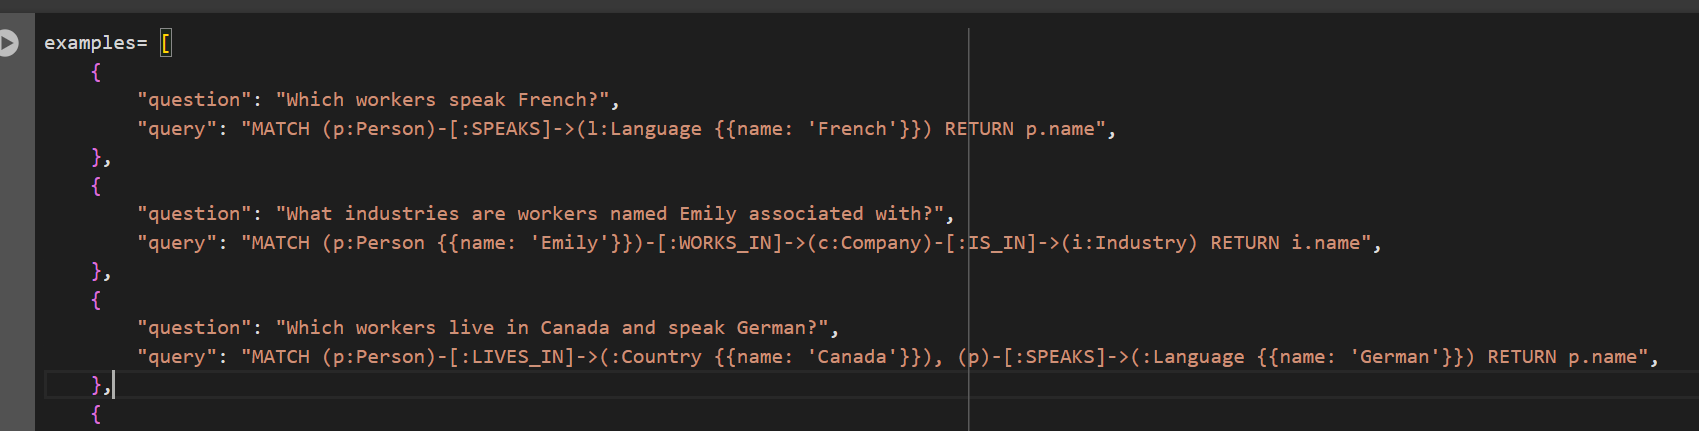

# Trial 3 - Dynamic Few Shot Prompting

In [37]:
from langchain_community.vectorstores import Neo4jVector
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_community.embeddings import HuggingFaceEmbeddings

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    HuggingFaceEmbeddings(),
    Neo4jVector,
    url = uri,
    username = auth[0],
    password = auth[1],
    k=3,
    input_keys=["question"],
)

C:\Users\mgupta70.ASURITE\AppData\Local\Temp\ipykernel_30536\3338117540.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  HuggingFaceEmbeddings(),
C:\Users\mgupta70.ASURITE\AppData\Local\Temp\ipykernel_30536\3338117540.py:7: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  HuggingFaceEmbeddings(),


In [38]:
example_selector.select_examples({"question": "Where do Michael work?"})

[{'query': "MATCH (p:Person {{name: 'John'}})-[:WORKS_IN]->(c:Company) RETURN c.name",
  'question': 'What companies do workers named John work in?'},
 {'query': "MATCH (p:Person {{name: 'Lukas'}})-[:WORKS_IN]->(c:Company) RETURN c.name",
  'question': 'What is the company that Lukas is working for?'},
 {'query': "MATCH (p:Person {{name: 'Alice'}})-[:LIVES_IN]->(c:Country) RETURN c.name",
  'question': 'Where do workers named Alice live?'}]

In [14]:
example_selector.select_examples({"question": "List all companies in advertising services industry!"})

[{'query': "MATCH (c:Company)-[:IS_IN]->(:Industry {{name: 'Software Development'}}) RETURN c.name",
  'question': 'Give me list of all companies are in the software development industry?'},
 {'query': "MATCH (c:Company)-[:IS_IN]->(:Industry {{name: 'Higher Education'}}) RETURN c.name",
  'question': 'What companies are in the higher education industry?'},
 {'query': "MATCH (p:Person {{name: 'John'}})-[:WORKS_IN]->(c:Company) RETURN c.name",
  'question': 'What companies do workers named John work in?'}]

In [39]:
dynamic_prompt = FewShotPromptTemplate(
    example_selector=example_selector, # previous: examples = examples[:3]
    example_prompt=example_prompt,
    prefix="You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.\n\nHere is the schema information\n{schema}.\n\nBelow are a number of examples of questions and their corresponding Cypher queries. Don't add any preambles, just return the correct cypher query",
    suffix="User input: {question}\nCypher query: ",
    input_variables=["question", "schema"],
)

In [40]:
print(dynamic_prompt.format(question="Where do Michael work?", schema= graph.schema))

You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.

Here is the schema information
Node properties:
- **Person**
  - `age`: STRING Example: "28"
  - `degree`: STRING Available options: ['Master', 'Bachelor']
  - `joining_year`: STRING Available options: ['2017', '2018', '2016', '2019']
  - `name`: STRING Example: "Paul Lukes"
- **Company**
  - `name`: STRING Example: "Toolbox Creative"
- **School**
  - `name`: STRING Example: "California College of the Arts"
- **Industry**
  - `name`: STRING Available options: ['Advertising Services', 'IT Services and IT Consulting', 'Hospitals and Health Care', 'Higher Education', 'Financial Services', 'Software Development', 'Real Estate']
- **Country**
  - `name`: STRING Example: "United States"
- **Language**
  - `name`: STRING Example: "English"
Relationship properties:

The relationships:
(:Person)-[:SPEAKS]->(:Language)
(:Person)-[:WORKS_IN]->(:Company)
(:Person)-[:LIVES_IN]->(:Country)
(:Person)

In [42]:
chain_with_dynamic_few_shot = GraphCypherQAChain.from_llm(graph=graph,
                                                          cypher_llm=cypher_model,
                                                          qa_llm=qa_model,
                                                          cypher_prompt=dynamic_prompt, # don't forget to change this into the dynamic_prompt
                                                          verbose=True,
                                                          validate_cypher = True,
                                                          use_function_response=False,
                                                          allow_dangerous_requests=True
                                                          )

for q in questions:
    print("\n", q)
    try:
        result = chain_with_dynamic_few_shot.invoke(q)['result']
        print(result)
    except:
        pass


 List all companies in advertising services industry!


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Company)-[:IS_IN]->(:Industry {name: 'Advertising Services'}) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}, {'c.name': 'Baked Advertising'}, {'c.name': 'Search Engine People'}]

> Finished chain.
Toolbox Creative, Baked Advertising, Search Engine People

 Where is Paul Lukes working?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: 'Paul Lukes'})-[:WORKS_IN]->(c:Company) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}]

> Finished chain.
Paul Lukes is working at Toolbox Creative.

 A worker residing in Canada who is proficient in Vietnamese?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:LIVES_IN]->(:Country {name: 'Canada'}), (p)-[:SPEAKS]->(:Language {name: 'Vietnamese'}) RETURN p.name
Full Context:
[{'p.name': 'Vitaly Nhuien'}]

> Finished chain.
I don't know t